In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt



training_set_size = 15
validation_set_size = 100
interval = 2
bit_much = 1   # to see what happens if we see a little bit outside our interval
epsilon_noise = 0.1
min_nodes = 500
max_nodes = 1000
max_epoch = 1500


In [2]:
# class SinApproximator(nn.Module):
    
#     def __init__(self, nodes=10):

#         super(SinApproximator, self).__init__()
        
#         self.fc = nn.Linear(2, nodes)  # Input: x, sin(x), rand()
#         self.hidden = nn.ReLU()
#         self.out = nn.Linear(nodes, 1)  # Output: approximated sin(x)

#     def forward(self, x):
#         x = self.hidden(self.fc(x))
#         x = self.out(x)
#         return x

class SinApproximator(nn.Module):
    def __init__(self, nodes=10):
        super(SinApproximator, self).__init__()
        
        self.fc = nn.Linear(2, nodes)
        self.fc2 = nn.Linear(nodes, nodes)
        self.fc3 = nn.Linear(nodes, nodes)
        self.fc4 = nn.Linear(nodes, nodes)
        self.fc5 = nn.Linear(nodes, nodes)
        self.fc6 = nn.Linear(nodes, nodes)
        self.out = nn.Linear(nodes, 1)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.out(x)
        return x


In [3]:
def generate_data(training_set_size, validation_set_size, how):

    if how=="linspace":
        x = np.linspace(-interval * np.pi, interval * np.pi, training_set_size)
    if how=="random":
        x = np.random.uniform(-interval*np.pi, interval*np.pi, training_set_size)


    noise_x = np.random.rand(training_set_size)  # Random noise    
    training_set_y =  np.sin(x) + np.random.normal(loc=0.0, scale=epsilon_noise, size=x.shape)
    training_set_x = np.vstack([x, noise_x]).T  # Combine x, and rand()

    validation_set_ = np.linspace(-interval * np.pi, interval * np.pi, validation_set_size)    
    validation_set_y = np.sin(validation_set_) + + np.random.normal(loc=0.0, scale=epsilon_noise, size=validation_set_.shape)
    validation_set_x = np.vstack([validation_set_, np.zeros_like(validation_set_)]).T


    
    return (torch.tensor(training_set_x, dtype=torch.float32), 
            torch.tensor(training_set_y, dtype=torch.float32).unsqueeze(1), 
            torch.tensor(validation_set_x, dtype=torch.float32),
            torch.tensor(validation_set_y, dtype=torch.float32))



In [4]:

# Training function
def train(model, X, y, validation_set, validaiton_set_y, num_epochs, learning_rate=0.01, lambda_reg=0.5, order=2):
    criterion = nn.MSELoss()
    optimizer = optim.RAdam(model.parameters(), lr=learning_rate)

    weights_b = []

    losses_validation = []
    losses_train = []

    for _epoch_ in range(num_epochs):
        
        optimizer.zero_grad()
        outputs = model(X)

        # Training loss
        plain_train_loss = criterion(outputs, y)

        # Regularization on weights associated with random input
        reg_loss = 0
        
        if order ==0:
            norm_weights = 0 
        if order == 1:
            norm_weights = torch.sum(torch.abs(model.fc.weight[:, 1]))     
        if order ==2:
            norm_weights = torch.sum(model.fc.weight[:, 1]**2)            
       
        reg_loss = lambda_reg * norm_weights  

        total_training_loss = plain_train_loss + reg_loss

        # Validation loss
        with torch.no_grad():
            validation_predicted = model(torch.tensor(validation_set, dtype=torch.float32))
            loss_validation = criterion(validation_predicted, validaiton_set_y)
            #returnvalloss = loss_validation+reg_loss
            losses_validation.append(loss_validation.item()) 

        # # train loss
        # with torch.no_grad():
        #     train_predicted = model(torch.tensor(X, dtype=torch.float32))
        #     loss_train = criterion(train_predicted, torch.sin(X[:,0]))
        #     losses_train.append(loss_train.item()) 



        losses_train.append(total_training_loss.item())
        weights_b.append(np.sum(model.fc.weight.data[:,1].numpy()))

        total_training_loss.backward()
        optimizer.step()


    
    return weights_b, losses_train, losses_validation

/var/folders/ft/czv55ht52cj81pgf47zl1dq80000gn/T/ipykernel_46360/74493972.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_predicted = model(torch.tensor(validation_set, dtype=torch.float32))
/opt/anaconda3/envs/qasmole3/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


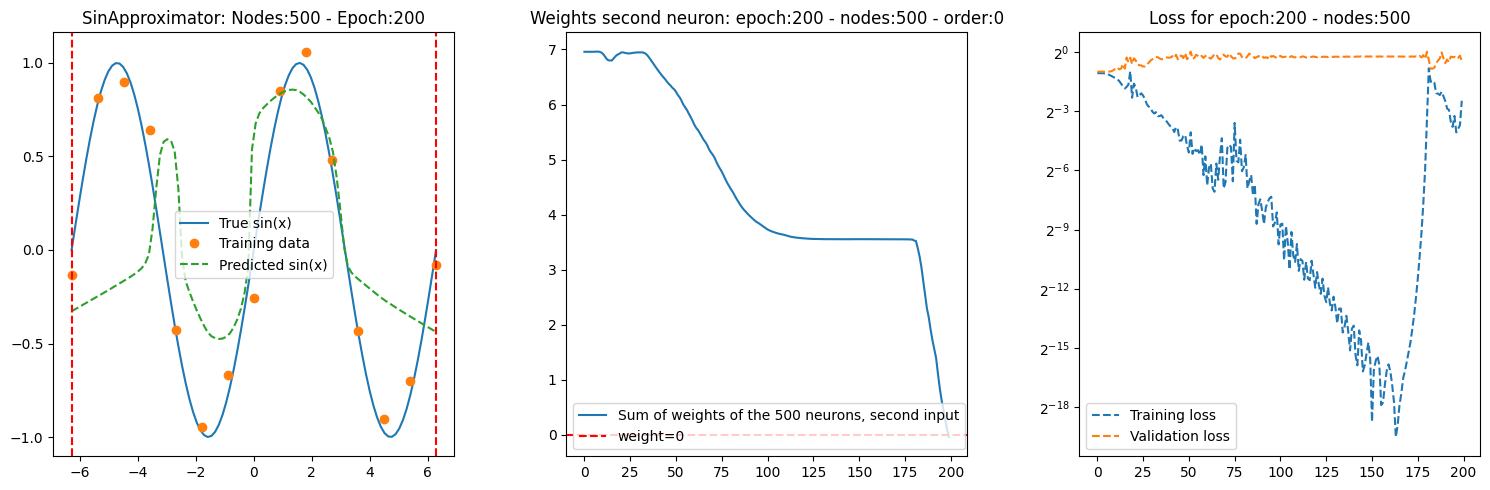

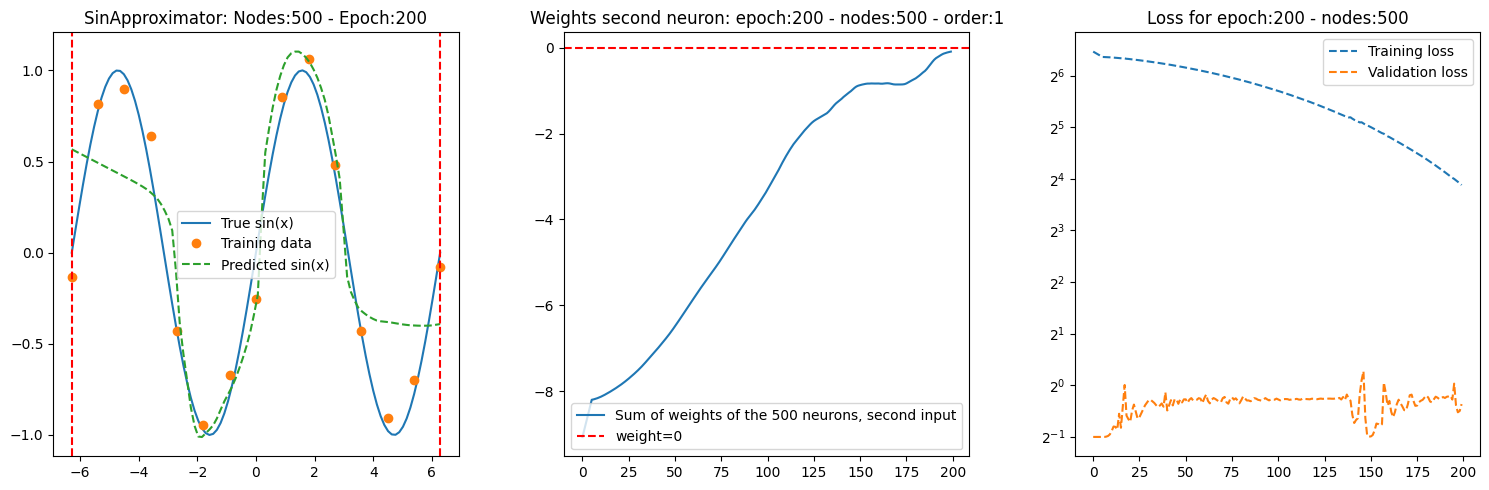

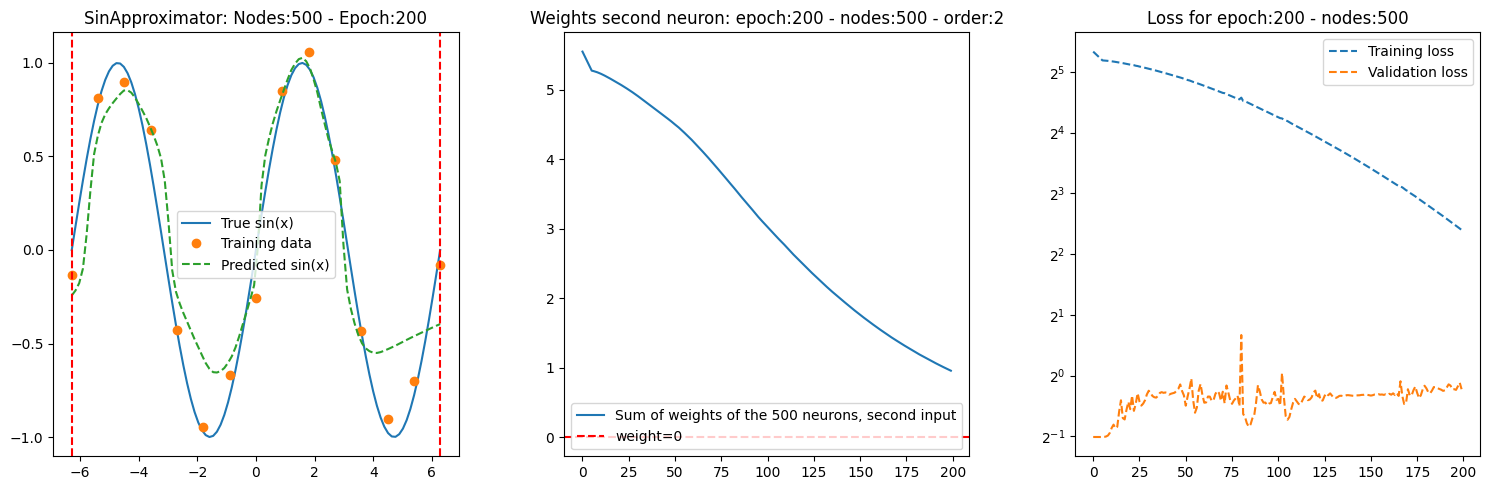

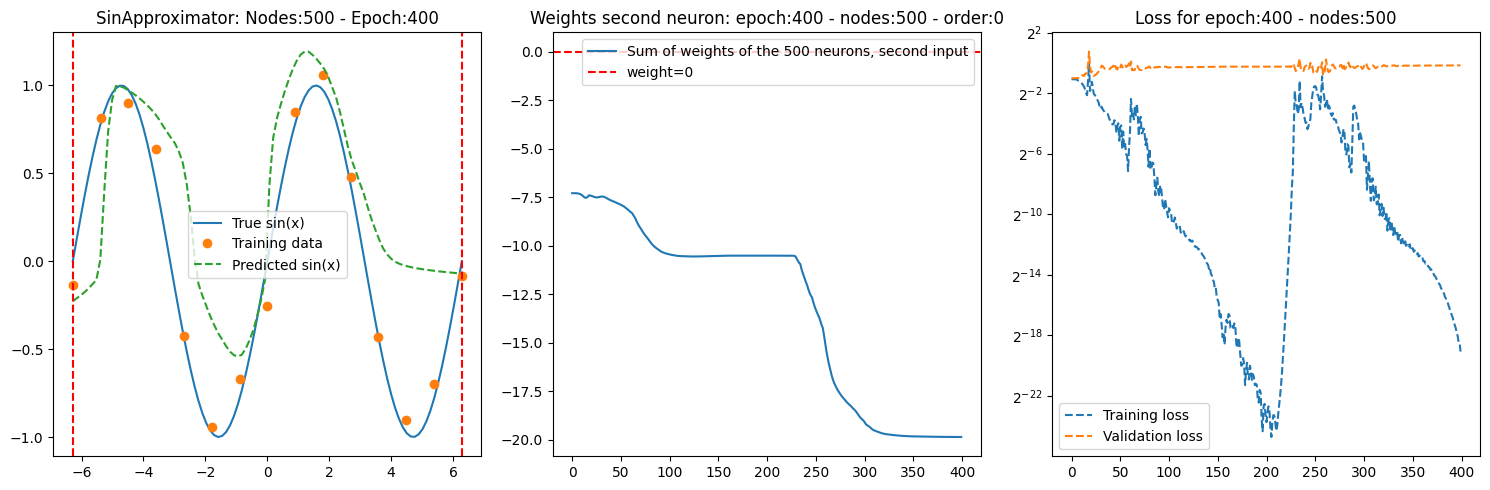

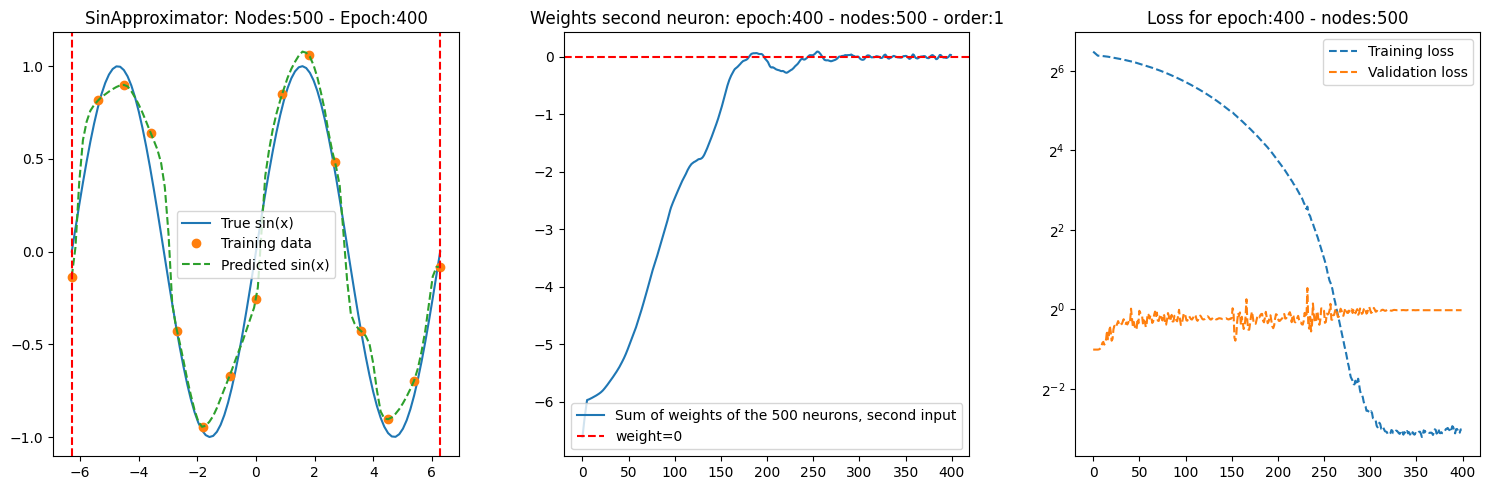

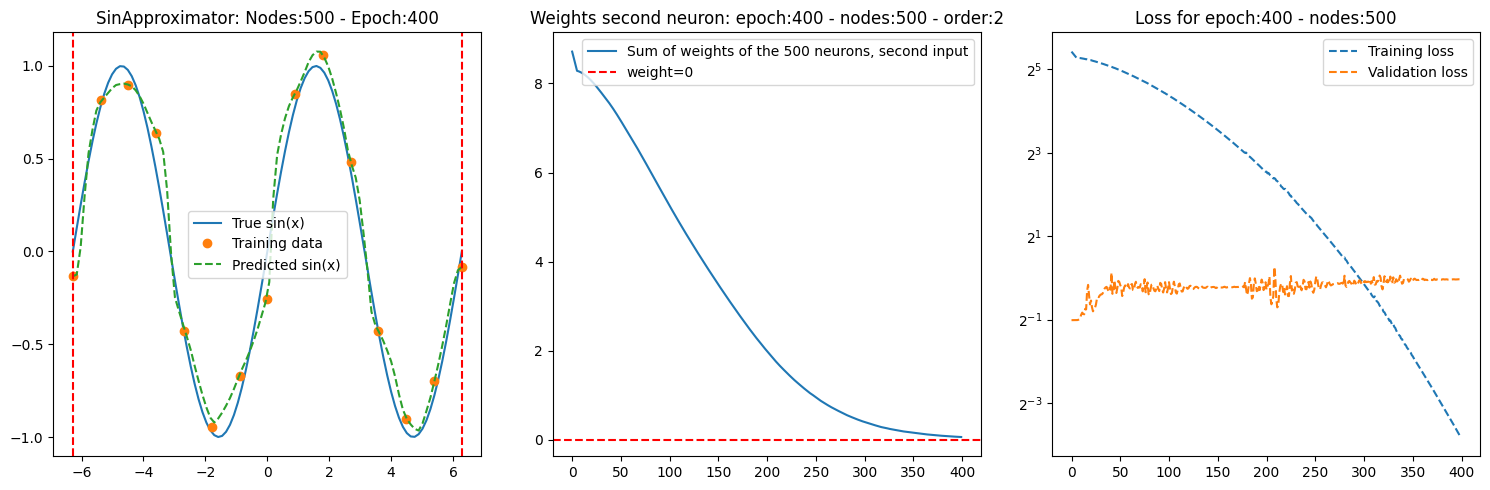

In [ ]:
# let's sample values to plot 
x_values = np.linspace(-interval *bit_much * np.pi, interval *bit_much * np.pi, 100)
x_values_ = np.vstack([x_values, np.zeros_like(x_values)])

training_X, training_y, validation, validation_y = generate_data(training_set_size, validation_set_size, how="linspace")

for nodes in range(min_nodes, max_nodes, 50):
    for epoch_number in range(200, max_epoch, 200):
        for order in (0,1,2):
                    
            model = SinApproximator(nodes=nodes)


            # Train the model
            weights_b, train_loss, val_loss = train(model, training_X, training_y, validation, validation_y, num_epochs=epoch_number, order=order)

            fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))


            with torch.no_grad():

                predictions = model(torch.tensor(x_values_.T, dtype=torch.float32)).numpy()

                # print(model.fc.weight[:, 1])
                # print(model.fc.weight[:, 0])

                axes[0].plot(x_values, np.sin(x_values), label="True sin(x)")
                axes[0].plot(training_X[:, 0], training_y, label="Training data", marker='o', linestyle='')
                axes[0].plot(x_values, predictions, label="Predicted sin(x)", linestyle="dashed")
                axes[0].set_title(f"SinApproximator: Nodes:{nodes} - Epoch:{epoch_number}")
                axes[0].axvline(x=-2*np.pi, color='red', linestyle='--')
                axes[0].axvline(x=2*np.pi, color='red', linestyle='--')

                axes[0].legend()

                axes[1].plot(weights_b, label=f"Sum of weights of the {nodes} neurons, second input")
                axes[1].set_title(f"Weights second neuron: epoch:{epoch_number} - nodes:{nodes} - order:{order}")
                axes[1].axhline(y=0, color='red', linestyle='--', label='weight=0')

                axes[1].legend()

                axes[2].plot(train_loss, label="Training loss", linestyle="dashed")
                axes[2].plot(val_loss, label="Validation loss", linestyle="dashed")
                axes[2].set_title(f"Loss for epoch:{epoch_number} - nodes:{nodes}")
                #axes[2].set_xscale('log', base=2)
                axes[2].set_yscale('log', base=2)
                axes[2].legend()

                # Adjust layout for better spacing
                plt.tight_layout()

                plt.show()
